# Candlestick Clusters using K-Means 

In this notebook, we're going to apply K-Means Clustering on SPDR Gold Shares(gold-backed ETF) to visualise candlestick clusters chart. We will also create the cluster matrix that describes the probability of cluster *i* to cluster *j*, which is useful for forming predictive trading strategies based on today's cluster identification and prediction of subsequent cluster.   

**The project outline is as follows:** 
1. Download and normalize asset prices data 
2. Apply K-Means Clustering and plot the candlestick chart   
3. Create Cluster Matrix 

### Import resources and create data

In [131]:
import datetime
import matplotlib.pyplot as plt
import mplfinance as mpf
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import pandas_datareader.data as data
from sklearn.cluster import KMeans
import copy

In [132]:
def get_prices (symbol, start, end):
    # download financial data frim Yahoo Finance
    gold_df = data.DataReader(symbol, "yahoo", start, end)
    df = pd.DataFrame()
    
    # normalize each candle by doing Adj Close/Open, High/low, and Low/Open 
    df["close/open"] = gold_df["Adj Close"]/gold_df["Open"]
    df["high/open"] = gold_df["High"]/gold_df["Open"]
    df["low/open"] = gold_df["Low"]/gold_df["Open"]
    return gold_df, df

### Plot Candlesticks chart with clusters 

In [133]:
def plot_candlestick_cluster(gold):
    
    # assign gold cluster column as the volume column so that we may plot the candlesticks chart with the cluster  
    gold["Volume"] = gold["Cluster"]
    gold.drop(["Adj Close"], axis=1, inplace=True)
    print(gold)
    
    # plot candlesticks chart, notice that the clusters are range from 0 to 9 
    mpf.plot(gold, type='candle', style= 'charles',title='Gold', 
             ylabel='Price ($)',volume=True, ylabel_lower='Cluster', 
             figratio=(30,20), figscale=2.0,warn_too_much_data=1500)

In [152]:
def plot_candlestick_sort_cluster(gold):
    
    # make deep copy of DataFrame so that they are not overwritten by each subsequent operation
    gold_cluster = copy.deepcopy(gold)
    
    # sort the data by cluster 
    gold_cluster.sort_values(by="Cluster", inplace=True)
    
    # reset index into cluster index, range from 0 to 500 
    gold_cluster.reset_index(inplace=True)
    gold_cluster["cluster_index"] = gold_cluster.index
    
    # create cluster dictionary for each different cluster, in our case, there are 10 clusters/states
    cluster_dict = {}
    for cluster in range(10):
        cluster_dict[cluster] = gold_cluster[gold_cluster["Cluster"] == cluster]
    
    # plot candlesticks chart with clusters sorted, notice that clusters are range from  
    gold_cluster.index = pd.DatetimeIndex(gold_cluster['cluster_index'])
    mpf.plot(gold_cluster, type='candle', style= 'charles',title='Gold', 
             ylabel='Price ($)',volume=True, ylabel_lower='Cluster', 
             figratio=(100,50), figscale=1.5,warn_too_much_data=1500)
    
    return cluster_dict

### Create Cluster Matrix

In [153]:
def create_cluster_matrix(gold):
    
    # shift the cluster and create new column which contains tomorrow's cluster value 
    gold["ClusterNext"] = gold["Cluster"].shift(-1)
    gold.dropna(inplace=True)
    gold["ClusterNext"] = gold["ClusterNext"].apply(int)
    
    # create a ClusterMatrix column by forming a tuple of today's cluster value and 
    # tomorrow's cluster value, a cluster pair
    gold["ClusterMatrix"]=list(zip(gold["Cluster"], gold["ClusterNext"]))
    
    # calculate the counts of each cluster pair and create a zero array of the matrix 
    vcounts = gold["ClusterMatrix"].value_counts() 
    cluster_matrix = np.zeros((10,10))
    
    # calculate the percentage frequency of occurence of each cluster pair and filled in cluster_matrix
    for row in vcounts.iteritems():
        cluster_matrix[row[0]] = (row[1]/len(gold))*100
    
    matrix_df = pd.DataFrame(np.round(cluster_matrix, 3))
    print ("Cluster Matrix:")
    print(matrix_df)   

### Specify symbol to download data, and apply K-Means clustering

                  High         Low        Open       Close  Volume  Cluster
Date                                                                       
2007-12-31   82.830002   81.980003   82.739998   82.459999       0        0
2008-01-02   85.139999   83.440002   83.559998   84.860001       9        9
2008-01-03   85.940002   84.599998   84.870003   85.570000       2        2
2008-01-04   85.550003   84.430000   85.339996   85.129997       0        0
2008-01-07   85.260002   84.570000   85.239998   84.769997       0        0
...                ...         ...         ...         ...     ...      ...
2009-12-24  108.370003  107.769997  107.900002  108.360001       8        8
2009-12-28  108.779999  107.910004  108.639999  108.550003       8        8
2009-12-29  108.500000  107.449997  108.500000  107.470001       0        0
2009-12-30  107.440002  106.400002  106.639999  106.930000       8        8
2009-12-31  108.110001  107.239998  107.980003  107.309998       0        0

[506 rows x

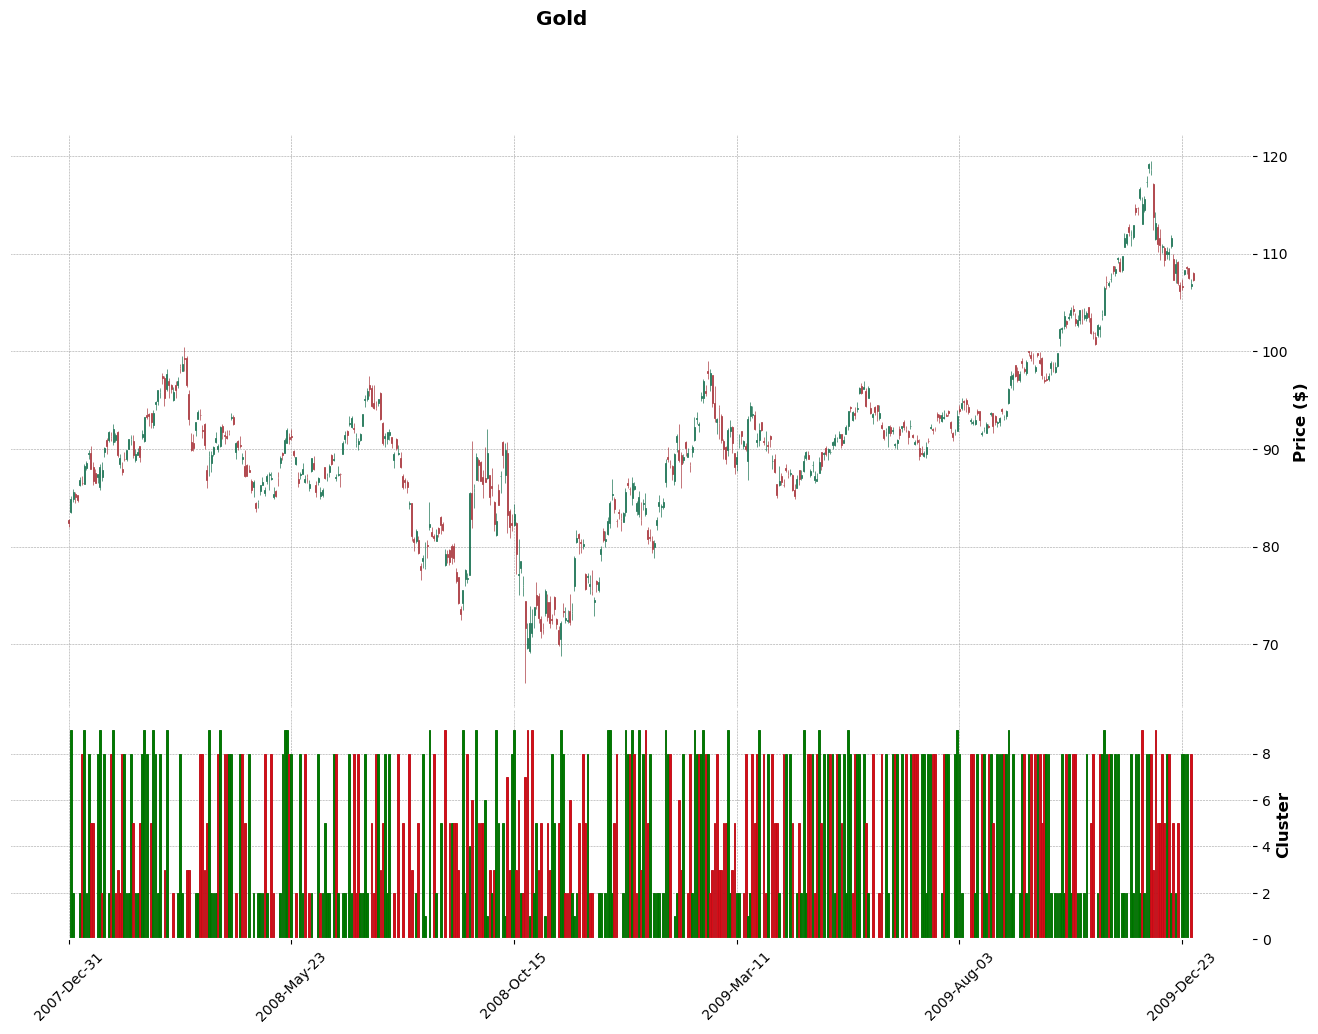

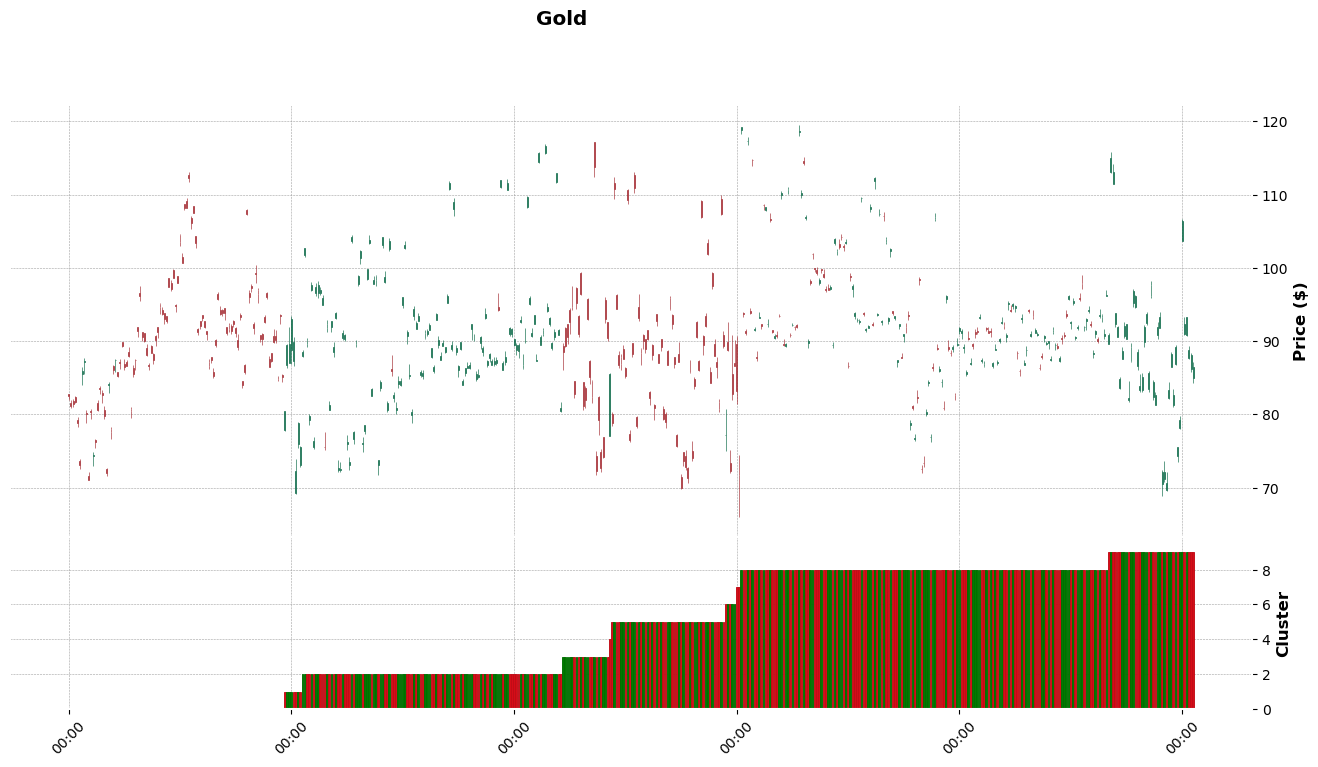

Cluster Matrix:
       0      1      2      3      4      5      6      7       8      9
0  2.772  0.396  5.743  0.396  0.000  1.584  0.000  0.000   7.129  0.990
1  0.198  0.000  0.594  0.198  0.000  0.198  0.000  0.198   0.000  0.198
2  5.149  0.198  4.752  0.792  0.000  1.782  0.396  0.198   8.317  1.584
3  0.594  0.000  0.396  0.396  0.000  1.188  0.198  0.000   0.792  0.594
4  0.000  0.000  0.000  0.000  0.000  0.000  0.198  0.000   0.000  0.000
5  2.376  0.198  1.584  0.594  0.000  1.782  0.198  0.000   2.574  0.792
6  0.198  0.198  0.396  0.198  0.000  0.000  0.000  0.000   0.000  0.000
7  0.000  0.000  0.000  0.198  0.000  0.000  0.000  0.000   0.000  0.198
8  6.733  0.396  7.327  0.990  0.198  2.574  0.000  0.000  11.485  2.970
9  0.990  0.198  2.376  0.396  0.000  0.990  0.000  0.000   2.376  0.396


In [154]:
if __name__=="__main__":
    symbol = "GLD"
    start = datetime.datetime(2008, 1, 1)
    end = datetime.datetime(2009, 12, 31)
    gold, gold_normalized = get_prices(symbol, start, end)
    
    # carry out K-Means clustering with 10 clusters
    k_means = KMeans(n_clusters=10)
    k_means.fit(gold_normalized)
    gold["Cluster"]= k_means.labels_
    
    # plot candlesticks chart with clusters 
    plot_candlestick_cluster(gold)
    
    # plot candlesticks chart with sorted clusters 
    cluster_dict = plot_candlestick_sort_cluster(gold)
    
    # create and output the cluster matrix
    create_cluster_matrix(gold)
    
    
    

**Candlesticks chart evaluation:** Based on the above candlesticks chart with sorted clusters output, cluster 0 represents slight down days while cluster 2 represents slight up days. Additionally, cluster 3 and 8 indicate severe drop days, while cluster 9 is severe up days. Finally a majority of the time is small volatility days, as in cluster 8.   

Cluster Matrix:
       0      1      2      3      4      5      6      7       8      9
0  2.783  0.398  5.765  0.398  0.000  1.590  0.000  0.000   6.958  0.994
1  0.199  0.000  0.596  0.199  0.000  0.199  0.000  0.199   0.000  0.199
2  5.169  0.199  4.771  0.795  0.000  1.789  0.398  0.199   8.350  1.590
3  0.596  0.000  0.398  0.398  0.000  1.193  0.199  0.000   0.795  0.596
4  0.000  0.000  0.000  0.000  0.000  0.000  0.199  0.000   0.000  0.000
5  2.386  0.199  1.590  0.596  0.000  1.789  0.199  0.000   2.584  0.795
6  0.199  0.199  0.398  0.199  0.000  0.000  0.000  0.000   0.000  0.000
7  0.000  0.000  0.000  0.199  0.000  0.000  0.000  0.000   0.000  0.199
8  6.561  0.398  7.356  0.994  0.199  2.584  0.000  0.000  11.531  2.982
9  0.994  0.199  2.386  0.398  0.000  0.994  0.000  0.000   2.386  0.398


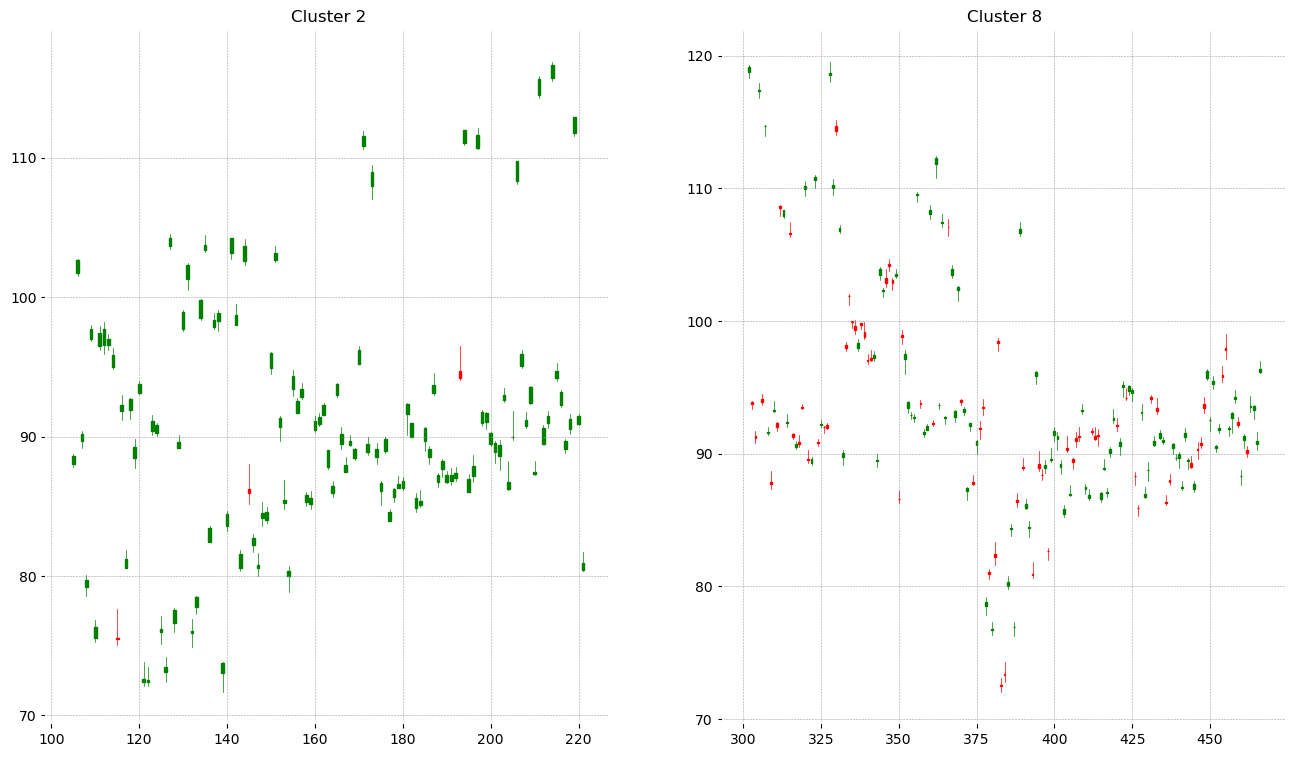

In [160]:
# plot the cluster pair that has the highest proabability
# hence plot cluster 2 and cluster 8 to visualize the candlesticks 
create_cluster_matrix(gold)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
ax1.set_title("Cluster 2")
candlestick_ohlc(ax1, cluster_dict[2][["cluster_index", "Open", "High", "Low", "Close",]].values, width=0.6, colorup='g', colordown='r')
ax2.set_title("Cluster 8")
candlestick_ohlc(ax2, cluster_dict[8][["cluster_index", "Open", "High", "Low", "Close",]].values, width=0.6, colorup='g', colordown='r')

plt.show()

**Conclusion & Matrix Evaluation:** Based on the table of the Cluster Matrix, we see that cluster 8 following cluster 8 has the highest probability (11.48%), this explains the prolonged consolidation period that is low in volatility. Another interesting phenomenon is that cluster 2 appears to follow cluster 8, and vice versa, this could be a valuable trading signal, for example buying gold when today's cluster state is 8, hoping that the next cluster state is 2 for our trade to be profitable. 

The K-Means Algorithm has its flaws, for example it is difficult to specify the right number of clusters for a financial pricing data and those clusters may not truly separate distributions of data. Another issue is that the predictive signal solely from the cluster matrix table is not strong enough for quant trader to execute trades on. Such issues motivate more sophisticated clustering algorithms such as integrating deep neural network architectures autoencoders to further extract the temporal dynamics of asset prices.  